In [1]:
import numpy as np
import pandas as pd

# cross validation purposes: create the cartesian product between the chosen values sets
from itertools import product 

import matplotlib.pyplot as plt
%matplotlib inline

#import os
#import seaborn

# Read Dataset

In [2]:
cmp = pd.read_csv("commViolUnnormData.txt", na_values='?')

In [3]:
# drop first non predictive features (communityname, state, countyCode, communityCode, "fold")
pred_features = cmp[cmp.columns[5:-18]]
regr_values = cmp[cmp.columns[-18:]]

# Drop features with a lot of missing values

In [4]:
print("Before dropping: {} features".format(str(pred_features.shape[1])))

#drop features that contain at least some threshold (from the total) of NaN values
cut_tresh = 0.75
to_drop = pred_features.columns[pred_features.count() < pred_features.shape[0]*cut_tresh]

pred_features = pred_features.drop(columns=to_drop)

print("After dropping: {} features".format(str(pred_features.shape[1])))

Before dropping: 124 features
After dropping: 102 features


# Imputing on features matrix

In [5]:
from collections import Counter

def value_withStrategy(v, strat):
    if strat == "mean":
        return np.mean(v)
    if strat == "median":
        return np.median(v)
    if strat == "most_frequent":
        return Counter(v).most_common(1)[0][0]
    print("Invalid imputing strategy!")
        
def imputing(df, strategy):
    # for each column that contain at least 1 NaN value...
    for nanCol in np.unique(np.where(pred_features.isna())[1]):
        nanRows = np.where(pred_features.iloc[:,nanCol].isna())[0] #find NaN rows for the current column
        available = df.iloc[~nanRows, nanCol]
        value = value_withStrategy(available, strategy) #compute the filling value
        df.iloc[nanRows, nanCol] = value

In [6]:
imputing(pred_features, "mean");

# Outliers Detection

-- TBD <br>
A thourough study from scratch of outliers detection is needed here, but for now it feels like it exceeds the course final project.

# Choose the Dependent Variable and drop possible missing values rows on it

In [7]:
def drop_naSample(df, vals):
    idxRow = np.where(vals.isna())[0]
    return df.drop(index=idxRow).values, vals.drop(index=idxRow).values.reshape(-1,1)

In [8]:
dep_var = "robbPerPop"
data,values = drop_naSample(pred_features, regr_values[dep_var])

# Exploratory Data Analysis

In [9]:
regr_values[dep_var].describe()

count    2214.000000
mean      162.612597
std       234.486624
min         0.000000
25%        27.647500
50%        74.800000
75%       187.155000
max      2264.130000
Name: robbPerPop, dtype: float64

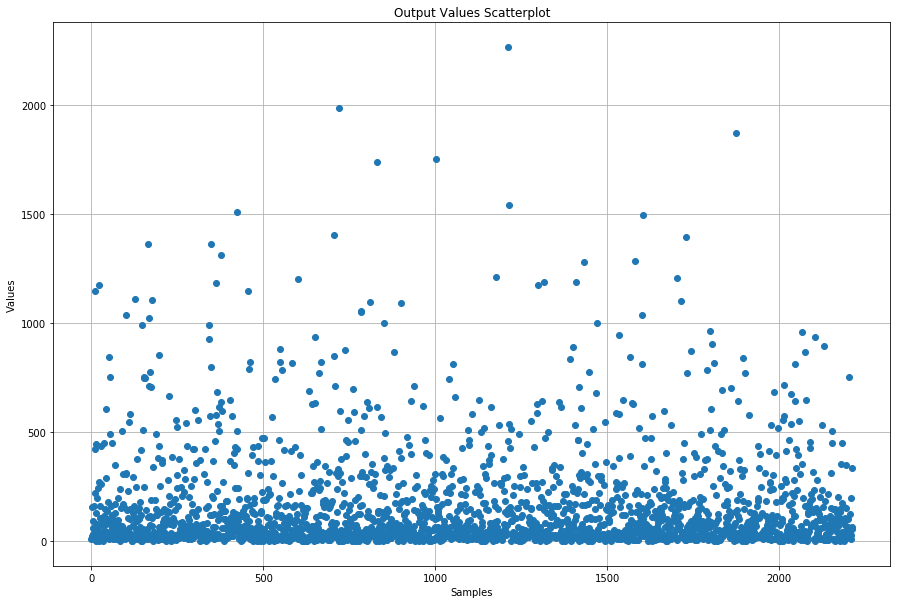

In [10]:
plt.figure(figsize=(15,10))
plt.plot(values, 'o')
plt.title("Output Values Scatterplot")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.grid()

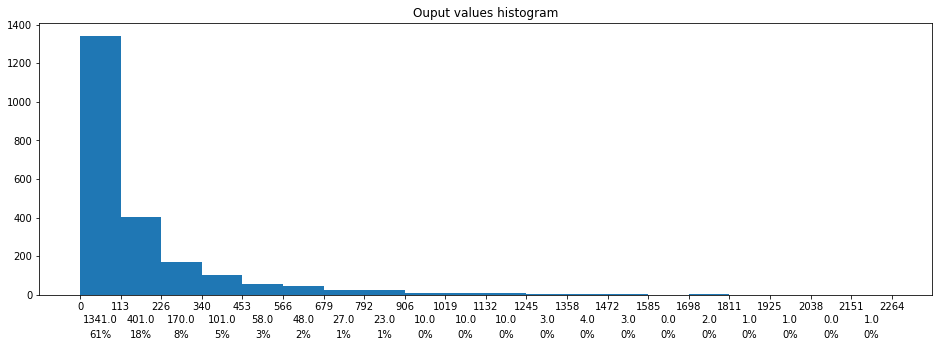

In [11]:
plt.figure(figsize=(16,5))
counts,bins,_ = plt.hist(values,bins=20)

bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    plt.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    plt.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center')
    
plt.title("Ouput values histogram")
plt.xticks(bins)
plt.show()

In [12]:
def sample_pearsonCorrelation_withOutput(X, y):
    # r_x_y = cov(x,y)/(stdev(x)*stdev(y))
    _,d = X.shape
    corr = np.empty((d,1))
    
    y_centered = y-np.mean(y)
    y_stdev = np.std(y)
    
    for i in range(d):
        current = X[:,i]
        corr[i] = np.mean(np.multiply(current-np.mean(current), y_centered))/(np.std(current)*y_stdev)
        
    return corr

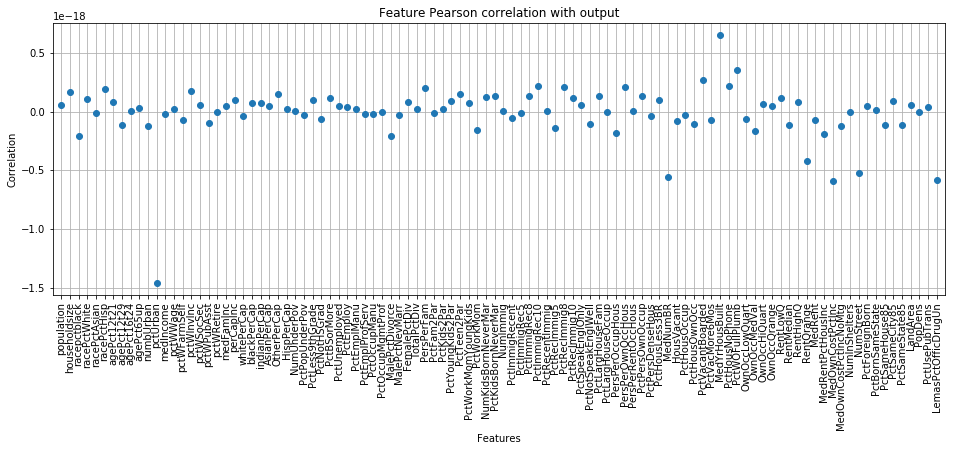

In [13]:
p_corr = sample_pearsonCorrelation_withOutput(data, values)

plt.figure(figsize=(16,5))
plt.plot(p_corr, "o")
plt.title("Feature Pearson correlation with output")
plt.xticks(range(len(pred_features.columns)), pred_features.columns, rotation=90)
plt.xlabel("Features")
plt.xlim(-1,102)
plt.ylabel("Correlation")
plt.grid()

# Normalisation

In [ ]:
def normalise(matrix, strat):
    for j in range(matrix.shape[1]):
        mi = np.min(matrix[:,j])
        ma = np.max(matrix[:,j])
        di = ma-mi
        if (di > 1e-6):
            if strat=="0_mean,1_std":
                matrix[:,j] = (matrix[:,j]-np.mean(matrix[:,j]))/np.std(matrix[:,j])
            elif strat=="[0,1]":
                matrix[:,j] = (matrix[:,j]-mi)/di
            elif strat=="[-1,1]":
                matrix[:,j] = 2*((matrix[:,j]-mi)/di)-1
            else:
                print("Invalid normalisation strategy!")
        else:
            matrix[:,j] = 0

In [ ]:
strategy = "[-1,1]"
normalise(data,strategy)
normalise(values,strategy)

# Train-Test Split

In [14]:
def trainTest_split(in_matrix, out_vect, train_amount=0.7):
    n,_ = in_matrix.shape

    trVl_Amount = int(n*train_amount) #training-validation amount
    indexes = np.random.permutation(n)
    idxTrVl = np.sort(indexes[0:trVl_Amount])
    idxTs = np.sort(indexes[trVl_Amount:])

    return in_matrix[idxTrVl], in_matrix[idxTs], out_vect[idxTrVl], out_vect[idxTs]

In [15]:
trainVal_data, test_data, trainVal_values, test_values = trainTest_split(data, values, train_amount=0.7)

# Evaluation Metrics

In [16]:
class Regression_evaluationMetric:
    def __init__(self, true, predicted):
        self.true = true.flatten()
        self.predicted = predicted.flatten()
        self.residuals = self.true-self.predicted
    
    def meanSquareError(self):
        return np.mean(np.square(self.residuals))
    
    def rootMeanSquareError(self):
        return np.sqrt(np.mean(np.square(self.residuals)))
    
    def meanAbsoluteError(self):
        return np.mean(np.abs(self.residuals))
    
    def rSquared(self):
        ss_residual = np.sum(np.square(self.residuals))
        ss_total = np.sum(np.square(self.true-np.mean(self.true)))        
        return 1 - ss_residual/ss_total
    
    def adjusted_rSquared(self, p):
        n = self.true.shape[0]
        return 1-(1-self.rSquared())*((n-1)/(n-p-1))


# Variable Selection - Models Definition

## 0. K-fold Cross Validation

In [17]:
from itertools import product

def kFold_crossValidation_selectionGrid(k, parameters_dict, train_data, train_values, predictor, verbose=False):
    nVal,_ = train_data.shape
    
    # Validation indexes adjustment -------------------------------
    elemPerFold, remainder = np.divmod(nVal,k) #the remainder will be distributed across the firsts folds
    valIdxList = []
    start = 0

    # in each fold put as many samples as the division quotient +1 if the remainder is still positive
    # then decrease the division remainder by 1
    for i in range(k): 
        end = start+elemPerFold+int(remainder>0)
        valIdxList.append(np.arange(start,end)) 
        remainder -= 1
        start = end
    
    # Cross validation --------------------------------------------
    params_names = parameters_dict.keys()
    params_product = list(product(*parameters_dict.values())) # build all the hyp-par combination
    val_results = np.empty((len(valIdxList),len(params_product)))
    
    for row, valIdx in enumerate(valIdxList): # for each fold
        if verbose: print("#{} fold:".format(row+1))
        for col, params in enumerate(params_product):
            
            if verbose:
                update = col*100/len(params_product) # just print completion rate
                print("\t["+"#"*(int(update/5))+" "*(int((100-update)/5))+"] {}%".format(update))
                     
            arg_dict = {k:v for k,v in zip(params_names,params)} # {argument_name:argument_value, ... }
            
            
            predictor.fit(train_data[~valIdx], train_values[~valIdx], **arg_dict)
            pred = predictor.predict(train_data[valIdx])
            
            rem = Regression_evaluationMetric(trainVal_values[valIdx], pred)
            #val_results[row,col] = rem.rSquared()
            val_results[row,col] = rem.rootMeanSquareError()
            
    selected = np.argmin(val_results.mean(axis=0))
    return params_product[selected]

## 1. Matching Pursuit - Not Working (use the sklearn model)

### Project class definition

In [18]:
class matchingPursuit:
    def __init__(self, iterations, weights = None, indexes = None):
        self.iterations = iterations
        self.weights = weights
        self.indexes = indexes
        
    def fit(self, data_matrix, output_vect):
        residual = output_vect.copy()
        self.weights = np.zeros((data_matrix.shape[1], 1))
        self.indexes = []

        #data_2norm = np.sqrt(np.sum(np.square(data_matrix), axis=0))
        data_2norm = np.linalg.norm(data_matrix, ord=2, axis=0).reshape(1,-1)

        for i in range(self.iterations):
            
            # project each column on the current residuals
            projection = np.matmul(residual.T, data_matrix)
            # find the most correlated variable: the one that in norm maximise the projections
            k = np.argmax(np.divide(np.square(projection), data_2norm))
            self.indexes.append(k)
            
            distance = projection[0,k]/np.linalg.norm(data_matrix[:,k], ord=2)
            self.weights[k,0] += distance # update the solution vector: canonical basis over the found column
            residual -= np.matmul(data_matrix, self.weights) # update the residual

        return self
    
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [19]:
mp = matchingPursuit(iterations=10)
mp.fit(trainVal_data, trainVal_values)
mp.sort_featureImportances(columns=pred_features.columns)

[('OwnOccHiQuart', array([-1.92935064e+65])),
 ('population', array([0.])),
 ('householdsize', array([0.])),
 ('racepctblack', array([0.])),
 ('racePctWhite', array([0.])),
 ('racePctAsian', array([0.])),
 ('racePctHisp', array([0.])),
 ('agePct12t21', array([0.])),
 ('agePct12t29', array([0.])),
 ('agePct16t24', array([0.])),
 ('agePct65up', array([0.])),
 ('numbUrban', array([0.])),
 ('pctUrban', array([0.])),
 ('medIncome', array([0.])),
 ('pctWWage', array([0.])),
 ('pctWFarmSelf', array([0.])),
 ('pctWInvInc', array([0.])),
 ('pctWSocSec', array([0.])),
 ('pctWPubAsst', array([0.])),
 ('pctWRetire', array([0.])),
 ('medFamInc', array([0.])),
 ('perCapInc', array([0.])),
 ('whitePerCap', array([0.])),
 ('blackPerCap', array([0.])),
 ('indianPerCap', array([0.])),
 ('AsianPerCap', array([0.])),
 ('OtherPerCap', array([0.])),
 ('HispPerCap', array([0.])),
 ('NumUnderPov', array([0.])),
 ('PctPopUnderPov', array([0.])),
 ('PctLess9thGrade', array([0.])),
 ('PctNotHSGrad', array([0.]))

In [20]:
pred = mp.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 3.4885948529068585e+140
Root Mean Square Error: 3.321593607407827e+70
R^2 score: -1.791428259490673e+136


### SkLearn Class

In [21]:
from sklearn.linear_model import orthogonal_mp
omp_coef = orthogonal_mp(trainVal_data, trainVal_values)
np.where(omp_coef)[0]

array([ 0, 19, 21, 23, 25, 27, 51, 81, 82, 99])

In [22]:
pred = np.matmul(test_data, omp_coef)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 114512.25514565856
Root Mean Square Error: 208.6222137903254
R^2 score: 0.29331230713923817


## 2. L1 Penalty (Lasso) with Proximal Gradient - Not Working (use the sklearn model)

### Project class definition

In [23]:
class lasso_regression: # Iterative Soft Thresholding Algorithm
    def __init__(self, iterations, weights=None):
        self.iterations = iterations
        self.weights = weights
        
    def fit(self, data_matrix, output_vect, _lambda):
        n,d = data_matrix.shape
        self.weights = np.zeros((d,1))
        
        # convergence step-size: n/(2*||X^t*X||_2)
        step = n/(2*np.linalg.norm(np.matmul(data_matrix.T, data_matrix), ord=2))
        softTresh = step*_lambda

        for i in range(self.iterations):
            # gradient step of the mse formulation
            resid = np.matmul(data_matrix, self.weights) - output_vect
            grad_descent = (step/n)*np.matmul(data_matrix.T, resid)
            self.weights -= 2*grad_descent

            # proximal operator
            upper = self.weights > softTresh  # elem to be reduced
            lower = self.weights < -softTresh # elem to be increased
            self.weights[upper] -= softTresh
            self.weights[lower] += softTresh
            self.weights[~upper & ~lower] = 0

        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [24]:
lr = lasso_regression(iterations=1000)
lr.fit(trainVal_data, trainVal_values, 0.5)
lr.sort_featureImportances(columns=pred_features.columns)

[('PopDens', array([0.00378645])),
 ('NumImmig', array([-0.00252737])),
 ('NumUnderPov', array([0.00215536])),
 ('whitePerCap', array([0.00205012])),
 ('NumKidsBornNeverMar', array([0.00145434])),
 ('AsianPerCap', array([0.0009486])),
 ('OwnOccQrange', array([0.00089944])),
 ('OtherPerCap', array([0.00083206])),
 ('OwnOccLowQuart', array([-0.00077852])),
 ('medIncome', array([-0.00077116])),
 ('MedYrHousBuilt', array([0.00077014])),
 ('indianPerCap', array([0.00065173])),
 ('HispPerCap', array([0.00044919])),
 ('numbUrban', array([0.00044362])),
 ('OwnOccMedVal', array([0.00039835])),
 ('population', array([0.00026968])),
 ('HousVacant', array([0.00024908])),
 ('medFamInc', array([-0.00017854])),
 ('blackPerCap', array([0.00012967])),
 ('OwnOccHiQuart', array([0.00012092])),
 ('perCapInc', array([0.00011867])),
 ('MedRent', array([9.97120357e-05])),
 ('RentHighQ', array([9.10165143e-05])),
 ('RentMedian', array([7.03910396e-05])),
 ('RentLowQ', array([4.7357628e-05])),
 ('RentQrange', 

In [25]:
pred = lr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 58723.69789181739
Root Mean Square Error: 244.06615704144784
R^2 score: 0.03278827006316276


### SkLearn Class

In [26]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.005)
lasso.fit(trainVal_data, trainVal_values)
np.where(lasso.coef_)[0]

/Users/danilo/.conda/envs/bcb/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [27]:
pred = lasso.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 116020.26569918066
Root Mean Square Error: 137.1545024124903
R^2 score: 0.6945595389345751


## 3. Random Forest

### Project Decision Tree class definition

In [28]:
class NumericalDecisionTree_regressor: # Least Square Regression Tree with either fixed parameter or pruning
    class Node:
        def __init__(self, isLeaf=False, feature=None, feature_importance=None, cut=None, average=None,
                     left=None, right=None):
            self.isLeaf = isLeaf
            self.feature = feature # if internal, on wich feature it executes the split
            self.feature_importance = feature_importance # solution variance reduction
            self.cut = cut # if internal, threahold value for the cut
            self.avg = average # mean of seen training values
            self.left = left
            self.right = right

        def print_tree(self):
            if self.left: self.left.print_tree()
            if self.cut:
                print("Feature: {}, cut: {}\n".format(self.feature, self.cut))
            else:
                print("Leaf => {}\n".format(self.avg))
            if self.right: self.right.print_tree()

        def print_tree_indented(self, level=0):
            if self.right: self.right.print_tree_indented(level+1)
            if self.cut:
                print("|    "*level+"{} => {}".format(self.feature, self.cut))
            else:
                print("|    "*level+"Leaf: {}".format(self.avg))                
            if self.left: self.left.print_tree_indented(level+1)
            
    def __init__(self, root=None, feature_importances=None):
        self.root = root
        self.feature_importances = feature_importances

        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=False):
        
        self.feature_importances = {k:0 for k in range(X.shape[1])}
        
        if not post_pruning:
            self.root = self.learn(X, y.flatten(), depth, minElems_perLeaf)
        else:
            # train dataset, pruning dataset
            X_trn, X_val, y_trn, y_val = trainTest_split(X, y.flatten(), train_amount=0.7)
            self.root = self.learn(X_trn, y_trn, depth, minElems_perLeaf)
            self.prune(X_val, y_val)
        
        return self
        
    def learn(self, X, y, depth, minElems_perLeaf):
        n, d = X.shape

        if depth==0 or n<=minElems_perLeaf: # leaf # or fraction error of the root node??? 
            return self.Node(isLeaf=True, average=np.mean(y))
            
        best_costDescent = np.float("-inf") # split that maximise the error descent

        for i1 in range(d):
            sorted_idx = np.argsort(X[:,i1])
            sorted_x, sorted_y = X[sorted_idx, i1], y[sorted_idx]

            s_right, s_left = np.sum(sorted_y), 0
            n_right, n_left = n, 0

            for i2 in range(n-1):
                s_left += sorted_y[i2]
                s_right -= sorted_y[i2]
                n_left += 1
                n_right -= 1
                
                if sorted_x[i2]<sorted_x[i2+1]: # for a different value
                    # try to maximise this value: it is directly correlated 
                    # to the possible split information gain
                    new_costDescent = (s_left**2)/n_left + (s_right**2)/n_right
                    if new_costDescent > best_costDescent:
                        best_costDescent = new_costDescent
                        best_feature = i1
                        best_cut = (sorted_x[i2]+sorted_x[i2+1])/2
                        
        # update the importance for the selected feature
        feature_importance = np.var(y) - (np.sum(np.square(y))-best_costDescent)/n
        self.feature_importances[best_feature] += feature_importance

        left_idxs = X[:,best_feature] < best_cut
        
        return self.Node(feature=best_feature, feature_importance=feature_importance,
                         cut=best_cut, average=np.mean(y),
                         left = self.learn(X[left_idxs], y[left_idxs], depth-1, minElems_perLeaf),
                         right = self.learn(X[~left_idxs], y[~left_idxs], depth-1, minElems_perLeaf))
    
    def prune(self, X, y):
        # for statistics purposes check errors on different dataset portions and average them
        # in order to decide whether to prune or not (same code of k-fold cross-validation)
        n,_ = X.shape
        folds = 5
        elemPerFold, remainder = np.divmod(n, folds)
        foldsIdxsList = []
        start = 0
        for i in range(folds): 
            end = start+elemPerFold+int(remainder>0)
            foldsIdxsList.append(np.arange(start,end)) 
            remainder -= 1
            start = end
        
        # recursive: start checking if the root receive a possible positive pruning from its sons
        self.test_pruning(self.root, X, y, foldsIdxsList)
        return self
    
    def test_pruning(self, node, X, y, foldIdxs):
        if node.isLeaf: # leaf: start point of new possible pruning
            return True
        
        # check sons response: if one of them is negative to be pruned it means that it performs an important
        # predictive split
        if not self.test_pruning(node.left, X, y, foldIdxs) or not self.test_pruning(node.right, X, y, foldIdxs):
            return False
        
        # else proceed with testing the goodness of the current node split
        folds = len(foldIdxs)
        results = np.empty(folds)

        # not pruned errors on different folds
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        not_prunErr = np.mean(results)

        # pruned errors on different folds
        node.isLeaf = True
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        # if pruning improves the prediction RMSE then keep current node as leaf
        node.isLeaf = np.mean(results) <= not_prunErr
        
        if node.isLeaf:
            # lower feature importance computed during training phase
            self.feature_importances[node.feature] -= node.feature_importance 
            node.left = None
            node.right = None
            
        return node.isLeaf
            
    def predict(self, X):
        if self.root is None:
            raise Exception("Tree not initialised! need to first fit the model")

        n,_ = X.shape
        y = np.empty(n)
        
        for i in range(n):
            current = self.root
            while not current.isLeaf:
                if X[i,current.feature] < current.cut:
                    current = current.left
                else:
                    current = current.right
                
            y[i] = current.avg
        
        return y
                
    def pprint(self):
        self.root.print_tree_indented()
        
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]
            
        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
            
        return sorted(zip(map(lambda kv: round(kv[1], 4), self.feature_importances.items()), columns),
                      reverse=True)[:n_printFeat]

In [29]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=5, minElems_perLeaf=10)
ndt.pprint()

|    |    |    |    |    Leaf: 1114.0733333333333
|    |    |    |    5 => 12.895
|    |    |    |    |    Leaf: 738.847
|    |    |    49 => 12552.5
|    |    |    |    |    Leaf: 598.2156862745098
|    |    |    |    100 => 1.1949999999999998
|    |    |    |    |    Leaf: 296.525
|    |    50 => 6.98
|    |    |    |    |    Leaf: 335.6677358490566
|    |    |    |    75 => 26.235
|    |    |    |    |    Leaf: 519.175
|    |    |    50 => 3.955
|    |    |    |    |    Leaf: 281.648947368421
|    |    |    |    51 => 10958.0
|    |    |    |    |    Leaf: 153.48000000000002
|    3 => 39.275000000000006
|    |    |    Leaf: 1560.86
|    |    100 => 17.7
|    |    |    |    |    Leaf: 672.395
|    |    |    |    38 => 13.870000000000001
|    |    |    |    |    Leaf: 1076.937
|    |    |    49 => 3359.5
|    |    |    |    Leaf: 550.652
49 => 2187.5
|    |    |    |    Leaf: 846.42125
|    |    |    41 => 14.155000000000001
|    |    |    |    |    Leaf: 1142.04
|    |    |    |    9

In [30]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 112332.95393458834
Root Mean Square Error: 137.73263093484667
R^2 score: 0.6919791496055934


In [31]:
ndt.sort_featureImportances()

[(100, 123503.5644027135),
 (49, 83648.8818561351),
 (96, 73164.17541728396),
 (41, 46943.36111736114),
 (3, 40628.65329319891),
 (5, 33404.60131838614),
 (50, 27500.939365408107),
 (38, 22729.75413388887),
 (0, 8877.674941043144),
 (69, 7249.492958745119),
 (75, 5997.968654641278),
 (44, 3634.457162664261),
 (51, 3231.994254803816),
 (4, 1987.536223330626),
 (99, 1377.2726766619817),
 (6, 287.8163049527111),
 (1, 0),
 (2, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (39, 0),
 (40, 0),
 (42, 0),
 (43, 0),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (70, 0),
 (

In [32]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10, post_pruning=True)
ndt.pprint()

|    |    |    |    |    Leaf: 1152.39875
|    |    |    |    39 => 41.11
|    |    |    |    |    Leaf: 687.14
|    |    |    43 => 36.620000000000005
|    |    |    |    Leaf: 1867.625
|    |    100 => 12.575
|    |    |    |    |    |    Leaf: 973.3924999999999
|    |    |    |    |    98 => 4.95
|    |    |    |    |    |    Leaf: 683.745
|    |    |    |    89 => 22.15
|    |    |    |    |    |    |    Leaf: 617.8733333333333
|    |    |    |    |    |    38 => 12.510000000000002
|    |    |    |    |    |    |    Leaf: 493.64000000000004
|    |    |    |    |    44 => 43.32
|    |    |    |    |    |    Leaf: 732.5577777777777
|    |    |    100 => 1.5099999999999998
|    |    |    |    |    Leaf: 472.0116666666666
|    |    |    |    26 => 6579.5
|    |    |    |    |    Leaf: 195.55375
|    50 => 9.094999999999999
|    |    |    |    Leaf: 835.06
|    |    |    92 => 117.0
|    |    |    |    |    Leaf: 1188.9
|    |    |    |    4 => 23.354999999999997
|    |    |    |    |  

In [33]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 109587.09368528043
Root Mean Square Error: 158.53152070607513
R^2 score: 0.5919271698499646


In [34]:
ndt.sort_featureImportances()

[(43, 96789.3052887713),
 (100, 86549.75624566073),
 (50, 55142.038194353285),
 (39, 42958.28326271059),
 (26, 24153.797726707482),
 (98, 20646.8486365057),
 (78, 19131.855500630467),
 (17, 14583.319418220424),
 (89, 13538.350798326468),
 (44, 13418.823748346193),
 (10, 12442.117971746635),
 (49, 11852.3353055675),
 (71, 10937.959779707347),
 (80, 10876.989531226143),
 (4, 7959.696495091666),
 (0, 7912.721575622178),
 (12, 7514.738002416236),
 (47, 7453.875354200374),
 (92, 7348.056615313246),
 (51, 6803.822546439437),
 (69, 6182.743158100549),
 (99, 6148.2201752339015),
 (33, 5799.824391783562),
 (46, 5157.674978936931),
 (14, 5131.17385340952),
 (54, 4928.538323350915),
 (3, 4897.637226508879),
 (38, 4575.550515024245),
 (28, 4515.82892561013),
 (65, 4502.056796860116),
 (24, 3573.5142102502195),
 (7, 3477.0282194116025),
 (2, 3345.463794376971),
 (72, 3177.5333712396687),
 (25, 2767.99000868056),
 (94, 2590.675908236315),
 (29, 2287.489492833205),
 (77, 2170.4265187500673),
 (21, 20

### Decision Tree SkLearn Class

In [35]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(trainVal_data, trainVal_values)
np.flip(np.argsort(dtr.feature_importances_))

array([ 49,  50,   3, 100,  69,  41,  96,  44,   2,  38,   0,  36,   5,
        22,  75,  55,   4,  99,  82,  39,  92,  29,  43,  59,  18,  25,
        51,  73,   6,  10,  45,  28,  30,  65,  21,  62,  88,  72,  26,
         7,  78,  48,  14,  60,  81,  47,  54,  40, 101,  95,  89,  23,
        93,  34,  17,  74,  98,  71,  13,  15,  24,  64,  86,  12,  27,
         9,  32,  97,  91,  31,  66,  52,  46,  33,  94,   8,  19,  37,
        85,  84,  67,  35,  20,  42,  77,  56,  76,   1,  57,  68,  16,
        80,  70,  61,  87,  90,  58,  83,  63,  11,  53,  79])

In [36]:
pred = dtr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 117402.8076492446
Root Mean Square Error: 153.59134389182302
R^2 score: 0.6169637211480552


### Project Random Forest class definition

In [37]:
class NumericalRandomForest_regressor: # post-pruning (kinda) with cross-validation or greedy 
    def __init__(self, n_trees, trees=None, bootstrap_subSpace=None, outOfBag_error=None, feat_importances=None):
        self.n_trees = n_trees
        self.trees = trees
        self.bootSamplesIdxs_SubSp = bootstrap_subSpace
        self.oob_error = outOfBag_error
        self.feature_importances = feat_importances
        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=True, verbose=False):
        n,d = X.shape
        
        self.trees = []
        self.bootSamplesIdxs_SubSp = []
        self.feature_importances = {k:0 for k in range(d)}
        
        n_learn = int(n/3) # Bootstrap amount to be taken aside
        # random subspace method amount
        d_learn = int(d/self.n_trees) if int(d/self.n_trees) >= int(np.sqrt(d)) else int(np.sqrt(d))
                
        # Fitting the forest -----------------------------------
        for i in range(self.n_trees):
            if verbose: print("\tFitting #{} tree".format(i+1))
            
            bootstrap_idxs = np.sort(np.random.permutation(n)[:n_learn])
            subspace_idxs = np.sort(np.random.permutation(d)[:d_learn])
            self.bootSamplesIdxs_SubSp.append((bootstrap_idxs, subspace_idxs))
                        
            dt = NumericalDecisionTree_regressor()
            
            self.trees.append(dt.fit(X[~bootstrap_idxs][:,subspace_idxs], y[~bootstrap_idxs],
                                     depth=depth, minElems_perLeaf=minElems_perLeaf, post_pruning=post_pruning))
            
            for k,v in dt.feature_importances.items():
                self.feature_importances[subspace_idxs[k]] += v
        
        # Out-Of-Bag Estimate for the forest -------------------
        oob_errors = []
        for sampleIdx in range(n):
            # finds all the tree that not have current sample in their bootstrapp set (not trained on it)
            # and the relative subspace on wich they have been trained
            missingTreesIdx_subspc = [(idx,subspace_idxs) for idx,(bootstrap_idxs,subspace_idxs)
                                      in enumerate(self.bootSamplesIdxs_SubSp)
                                      if sampleIdx not in bootstrap_idxs]

            if len(missingTreesIdx_subspc) == 0: continue
            
            regr_results = np.empty(len(missingTreesIdx_subspc)) # regression estimate of the selected trees
            for i, (missingTree_idx, tree_subSpace) in enumerate(missingTreesIdx_subspc):
                # reshape in order to correctly use the decision_tree.predict(...): it needs a matrix (num,dim)
                # while numpy matrix indexing returns (dim,)
                regr_results[i] = self.trees[missingTree_idx].predict(X[sampleIdx,tree_subSpace].reshape(1,-1))
            
            # done at this level of granularity because a sample might end up in 
            # being part of no bootstrap set of any tree (so we cannot predict wich value in y will be used)
            oob_errors.append(np.square(y[sampleIdx]-np.mean(regr_results)))
            #oob_errors.append(r2_score(np.mean(regr_results),y[sampleIdx]))
            #oob_errors.append(explained_variance_score(np.mean(regr_results),y[sampleIdx]))
            
        self.oob_error = np.sqrt(np.mean(oob_errors))
        return self
            
        
    def predict(self,X):
        if len(self.trees)==0:
            raise Exception("Trees not initialised! need to first fit the model")

        n,_ = X.shape
        results = np.empty((self.n_trees,n))
        for row, (tree,(_,subspace_idxs)) in enumerate(zip(self.trees, self.bootSamplesIdxs_SubSp)):
            results[row] = tree.predict(X[:,subspace_idxs])
            
        return np.mean(results,axis=0)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

In [43]:
n_trees = [1,10,20,30,50,70,100,150,200]
oob_errors = np.empty(len(n_trees))
for i, num_t in enumerate(n_trees):
    print("Training {} trees".format(num_t))
    nrf = NumericalRandomForest_regressor(num_t)
    # no train and test, cause it's a forest
    nrf.fit(data, values, depth=100, minElems_perLeaf=5);
    oob_errors[i] = nrf.oob_error

Training 1 trees
Training 10 trees
Training 20 trees
Training 30 trees
Training 50 trees
Training 70 trees
Training 100 trees
Training 150 trees
Training 200 trees


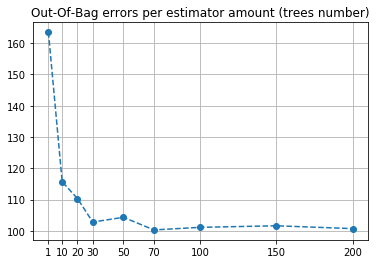

In [45]:
plt.title("Out-Of-Bag errors per estimator amount (trees number)")
plt.errorbar(n_trees,oob_errors, fmt='--o');
plt.xticks(n_trees)
plt.grid()

### Random Forest SkLearn class

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
# oob error not working, need to perform evaluation on test split
rfr.fit(trainVal_data, trainVal_values.ravel())
np.flip(np.argsort(rfr.feature_importances_))

In [ ]:
pred = rfr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

# Predictors - Models definition

## 1. Regularised Least Squares
   

In [ ]:
class tikhonov_leastSquares:
    def __init__(self, weights = None):
        self.weights = weights
        
    def fit(self, X, y, _lambda):
        inv = np.linalg.inv(np.matmul(X.T, X) + _lambda*np.eye(X.shape[1]))
        self.weights = np.matmul(inv, np.matmul(X.T, y))
        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)

In [ ]:
k = 5
params_dict = {"_lambda":[1,1.3,1.5,1.7,2]}

tls = tikhonov_leastSquares()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, tls)[0]
print("Best regulariser: {}".format(win_regulariser))
tls.fit(trainVal_data, trainVal_values, win_regulariser)
pred = tls.predict(test_data)

rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

## 2. Random Forest

In [ ]:
rf = NumericalRandomForest_regressor(100)
rf.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10);

pred = rf.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

In [ ]:
rf.oob_error

In [ ]:
rf.sort_featureImportances()

## 3. SVM - Not Working (use the sklearn model)

In [ ]:
class linear_SupportVector_regression:
    def __init__(self, weight=None, alpha=None, bias=None):
        self.x = alpha
        self.w = weight
        self.bias = bias
        self.Nabla = None
                
    def SMO2_ab(self, n, H, f, a, LB, UB, maxiter, eps, alpha_s):
        """
        % min_{x} .5 x H x + f' x 
        %         LB <= x <= UB
        %         a' x = b
        % n         grandezza problema length(x)
        % maxiter   max num it
        % eps       precisione
        % alpha_s   punto di inizio valido per x
        % Nabla     ....
        % err       flag di ok
        % x         valore della soluzione ottima
        % bias      ....
        """
        self.x = alpha_s
        self.Nabla = f
        for i in range(n):
            if (self.x[i] != 0.0):
                for j in range(n):
                    self.Nabla[j] += H[j,i] * self.x[i]
        iter_ = 0
        while True:
            minF_up = float("inf");
            maxF_low = float("-inf");
            for i in range(n): 
                F_i = self.Nabla[i]/a[i]
                if (LB[i] < self.x[i]) and (self.x[i] < UB[i]) :
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
                elif (((a[i] > 0) and (self.x[i] == LB[i])) or ((a[i] < 0) and (self.x[i] == UB[i]))) : 
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                elif (((a[i] > 0) and (self.x[i] == UB[i])) or ((a[i] < 0) and (self.x[i] == LB[i]))) : 
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
            if ((maxF_low - minF_up) <= eps):
                err = 0.0
                break

            iter_ += 1
            if (iter_ >= maxiter):
                err = 1.0
                break

            if (a[u] > 0):
                tau_lb = (LB[u]-self.x[u])*a[u] 
                tau_ub = (UB[u]-self.x[u])*a[u] 
            else:
                tau_ub = (LB[u]-self.x[u])*a[u] 
                tau_lb = (UB[u]-self.x[u])*a[u]

            if (a[v] > 0):
                tau_lb = max(tau_lb,(self.x[v]-UB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-LB[v])*a[v]) 
            else:
                tau_lb = max(tau_lb,(self.x[v]-LB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-UB[v])*a[v])

            tau = (self.Nabla[v]/a[v]-self.Nabla[u]/a[u])/(H[u,u]/(a[u]*a[u])
                                                           +H[v,v]/(a[v]*a[v])
                                                           -2*H[v,u]/(a[u]*a[v]))
            tau = min(max(tau,tau_lb),tau_ub)
            self.x[u] += tau/a[u]
            self.x[v] -= tau/a[v]

            for i in range(n):
                self.Nabla[i] += H[u,i]*tau/a[u] - H[v,i]*tau/a[v]

        tsv = 0
        self.bias = 0.0

        for k in range(n):
            if ((self.x[k] > LB[k]) and (self.x[k] < UB[k])):
                self.bias -= self.Nabla[k]/a[k]
                tsv += 1

        if (tsv > 0):
            self.bias /= tsv
        else:    
            self.bias = -(maxF_low + minF_up)/2.0

        return err
    
    def fit(self, X, y, C):
        n = X.shape[0]
        cov = np.matmul(X, X.T)
        Q = np.matmul(np.matmul(np.diag(y.flatten()), cov),
                      np.diag(y.flatten()))
        
        if self.SMO2_ab(n,Q,-np.ones(n),y.flatten(),
                   np.zeros(n),C*np.ones(n),10000000,.0001,np.zeros(n)):
            print("Problem in SMO")
            
        self.w = np.matmul(np.matmul(X.T, np.diag(y.flatten())),
                           self.x)
        
        return self
    
    def predict(self, X):
        return np.matmul(X, self.w) + self.bias

In [ ]:
lsvr = linear_SupportVector_regression()
lsvr.fit(trainVal_data, trainVal_values, C=1.0);

pred = lsvr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

In [ ]:
np.where(lsvr.x)

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel="linear", tol=.0001, C=1)
svr.fit(trainVal_data, trainVal_values.flatten());

In [ ]:
np.where(svr.dual_coef_)[1]

In [ ]:
pred = svr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

# Recursive Features Elimination
<img src="img/Algo1.png">

In [ ]:
nrf = NumericalRandomForest_regressor(100)
nrf.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=5, verbose=True);

In [ ]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances()

In [ ]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances(columns=pred_features.columns)

In [ ]:
def rfe(estimator, parameters_dict, data, vals, n_features=None, verbose=False):
    _,d = data.shape
    nf = n_features if n_features else int(d/2)
    train_feat = list(range(d))    
    rmse = []
    r2 = []

    tr_data, ts_data, tr_vals, ts_vals = trainTest_split(in_matrix=data, out_vect=vals, train_amount=0.7)
    
    while d > nf:
        if verbose:
            update = round((data.shape[1]-d)*100/(data.shape[1]-nf), 2) # just print completion rate
            print("\t["+'#'*(int(update/5))+' '*(int((100-update)/5))+"] {}%".format(update))
            
        estimator.fit(X=tr_data[:,train_feat], y=tr_vals, **parameters_dict)
        pred = estimator.predict(ts_data)
        rem = Regression_evaluationMetric(ts_vals, pred)
        rmse.append(rem.rootMeanSquareError())
        r2.append(rem.rSquared())
            
        rank = estimator.sort_featureImportances()
        toDiscard_idx = rank[-1][0]
        train_feat.remove(train_feat[toDiscard_idx])

        d -= 1
    
    return (rmse, r2, train_feat)

In [ ]:
p_dict = {"depth":200, "minElems_perLeaf":5, "post_pruning":True, "verbose":False}
rootMSE, r2, surv_feature = rfe(NumericalRandomForest_regressor(100),
                                p_dict, trainVal_data, trainVal_values, verbose=True)

In [ ]:
plt.figure(figsize=(10,5))
x = range(trainVal_data.shape[1],len(surv_feature),-1)
plt.plot(x, rootMSE, label="RMSE")
#plt.plot(x, r2, label="R2")

plt.legend()
plt.xlim(trainVal_data.shape[1], len(surv_feature))
#range(trainVal_data.shape[1],len(surv_feature),-1)
plt.xlabel("Number of Features")
plt.ylabel("Root Mean Square Error")
plt.grid()

In [ ]:
rootMSE

In [ ]:
pred_features.columns[surv_feature]